In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE # Dengesiz veri için

print("Kütüphaneler başarıyla yüklendi.")

Kütüphaneler başarıyla yüklendi.


In [ ]:
# GitHub 'raw' linkini buraya yapıştırın
url = 'https://raw.githubusercontent.com/Efeyamann/StrokePrediction/main/healthcare-dataset-stroke-data.csv'
df = pd.read_csv(url)

# Veriye ilk bakış
print(df.head())
print("\nEksik Veriler:\n", df.isnull().sum())

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  

Eksik Veriler:
 id                     0
gender        

In [ ]:
# 1. Eksik değerleri (BMI) medyan ile dolduralım
df['bmi'].fillna(df['bmi'].median(), inplace=True)

# 2. Gereksiz kolonu (id) çıkaralım
df.drop(['id'], axis=1, inplace=True)

# 3. Kategorik verileri Encode edelim (Sayıya çevirelim)
le = LabelEncoder()
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Özellikler ve Hedef değişkeni ayıralım
X = df.drop('stroke', axis=1)
y = df['stroke']

print("Veri ön işleme tamamlandı.")

Veri ön işleme tamamlandı.


/tmp/ipython-input-3228437098.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].median(), inplace=True)


In [ ]:
# Veriyi Eğitim ve Test olarak bölelim
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE uygulayarak azınlık sınıfı (stroke=1) artıralım
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Ölçeklendirme (Scaling) - Modellerin daha iyi çalışması için şart
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

print(f"Eğitim seti boyutu (Dengelenmiş): {X_train_res.shape}")

Eğitim seti boyutu (Dengelenmiş): (7802, 10)


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = []

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({"Model": name, "Accuracy": acc, "F1-Score": f1})

# Sonuçları DataFrame'e çevirelim
results_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)
print(results_df)

                 Model  Accuracy  F1-Score
0  Logistic Regression  0.784736  0.256757
2                  SVM  0.810176  0.198347
3        Decision Tree  0.863992  0.177515
1        Random Forest  0.896282  0.145161
4              XGBoost  0.899217  0.134454


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:28:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/tmp/ipython-input-2726006191.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')


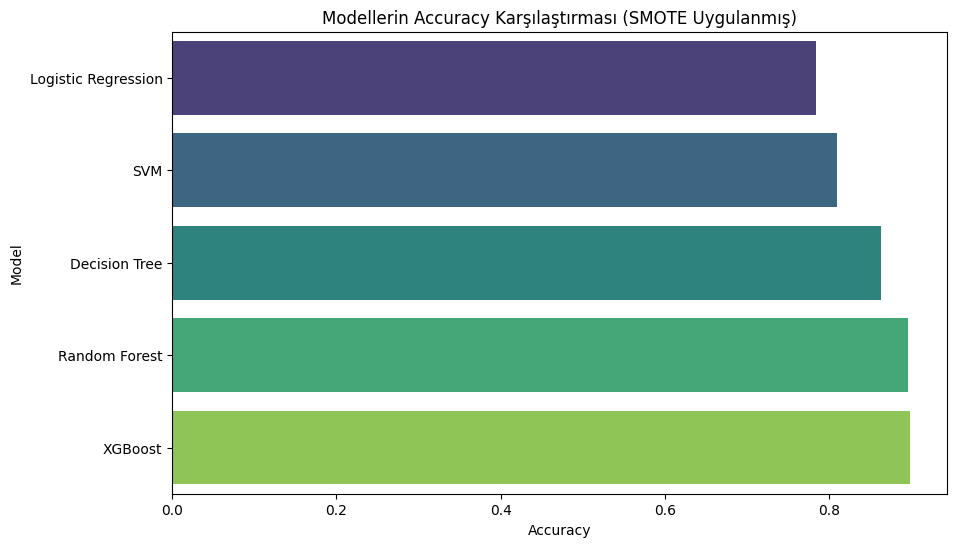

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Modellerin Accuracy Karşılaştırması (SMOTE Uygulanmış)')
plt.show()

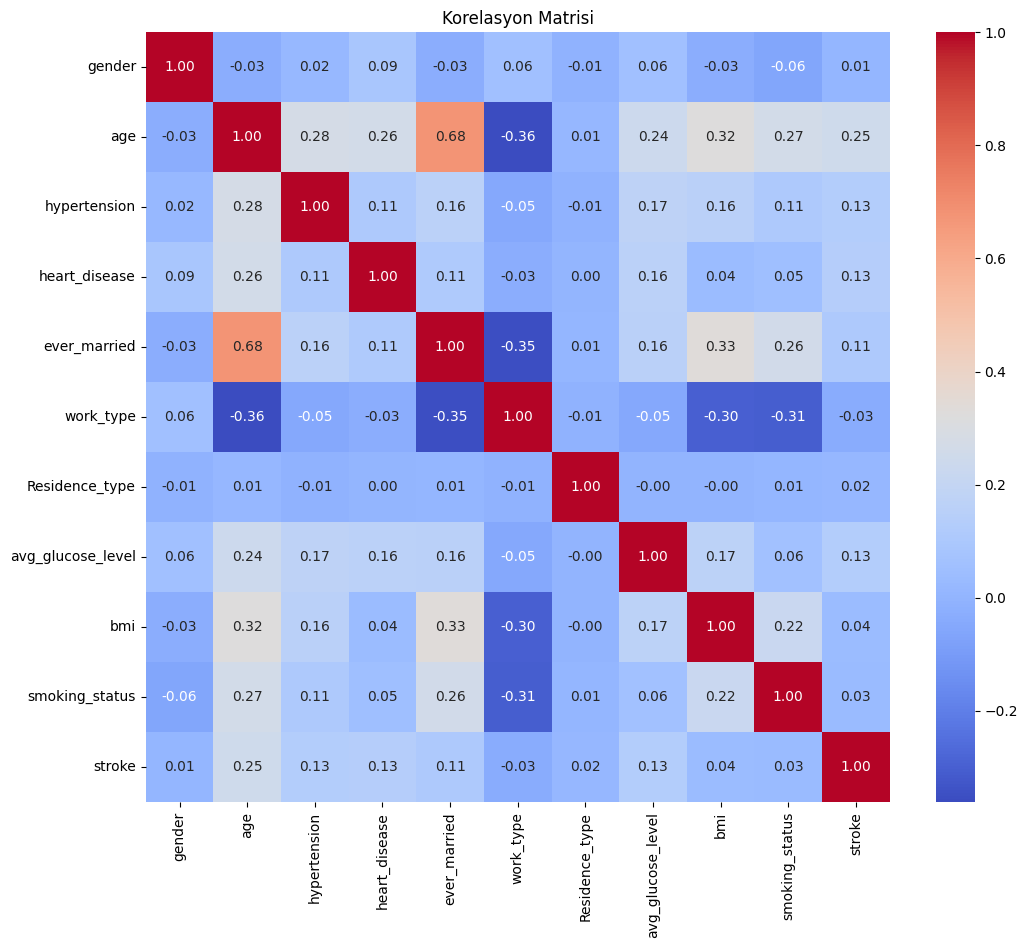

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Korelasyon matrisini hesapla
correlation_matrix = df.corr()

# Korelasyon matrisini ısı haritası olarak görselleştir
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasyon Matrisi')
plt.show()

Eğitilen modellerin doğruluk oranlarına bakarsak:

**XGBoost modeli** %89.92 ile en yüksek doğruluk oranına sahipken,<br>
**Random Forest** %89.62 ile onu takip ediyor.<br>
**Decision Tree modeli** %86.39 doğruluk oranına sahip.<br>
**SVM modeli** %81.01 doğruluk oranına sahipken,<br>
**Logistic Regression modeli** %78.47 ile en düşük doğruluk oranına sahip.<br>

Ancak, inme tahmini gibi dengesiz veri setlerinde sadece doğruluk oranına bakmak yanıltıcı olabilir. Bu yüzden F1-Score gibi metrikleri de göz önünde bulundurmak önemlidir. F1-Score açısından Logistic Regression modelinin diğer modellere göre daha iyi performans gösterdiği görülmektedir, bu da dengesiz veri setlerinde daha iyi bir denge sağladığını düşündürmektedir.